# 데이터 분석

- `[단어 - 라벨 - boxes - boxes_center] column을 가지는 DataFrame을 만들어 데이터 분석하기`
    - 라벨 별 boxes의 위치 분포 확인하기 → **box의 위치**가 **라벨 예측**에 도움을 줄 수 있는가?

## [단어 - 라벨 - boxes - boxes_center] column을 가지는 DataFrame을 만들어 데이터 분석하기

### example 만들기

In [1]:
import os
import pandas as pd

In [2]:
class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels, boxes, actual_bboxes, file_name, page_size):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
            boxes: (Optional) list. The bounding boxes of the words in the sequence.
            actual_bboxes: (Optional) list. The actual bounding boxes of the words in the sequence.
            file_name: (Optional) str. The name of the file.
            page_size: (Optional) list. The size of the page.
        """
        self.guid = guid
        self.words = words
        self.labels = labels
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


def read_examples_from_file(data_dir, mode):
    file_path = os.path.join(data_dir, "{}.txt".format(mode))
    box_file_path = os.path.join(data_dir, "{}_box.txt".format(mode))
    image_file_path = os.path.join(data_dir, "{}_image.txt".format(mode))
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f, open(
        box_file_path, encoding="utf-8"
    ) as fb, open(image_file_path, encoding="utf-8") as fi:
        words = []
        boxes = []
        actual_bboxes = []
        file_name = None
        page_size = None
        labels = []
        for line, bline, iline in zip(f, fb, fi):
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                if words:
                    examples.append(
                        InputExample(
                            guid="{}-{}".format(mode, guid_index),
                            words=words,
                            labels=labels,
                            boxes=boxes,
                            actual_bboxes=actual_bboxes,
                            file_name=file_name,
                            page_size=page_size,
                        )
                    )
                    guid_index += 1
                    words = []
                    boxes = []
                    actual_bboxes = []
                    file_name = None
                    page_size = None
                    labels = []
            else:
                splits = line.split("\t") # [word, label]
                bsplits = bline.split("\t") # [word, box]
                isplits = iline.split("\t") # [word, actual_bbox, page_size, file_name]
                assert len(splits) == 2
                assert len(bsplits) == 2
                assert len(isplits) == 4
                assert splits[0] == bsplits[0]
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                    box = bsplits[-1].replace("\n", "")
                    box = [int(b) for b in box.split()]
                    boxes.append(box)
                    actual_bbox = [int(b) for b in isplits[1].split()]
                    actual_bboxes.append(actual_bbox)
                    page_size = [int(i) for i in isplits[2].split()]
                    file_name = isplits[3].strip()
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words: # if file does not end with a newline
            examples.append(
                InputExample(
                    guid="%s-%d".format(mode, guid_index),
                    words=words,
                    labels=labels,
                    boxes=boxes,
                    actual_bboxes=actual_bboxes,
                    file_name=file_name,
                    page_size=page_size,
                )
            )
    return examples

In [3]:
train_examples = read_examples_from_file("data", "train")
test_examples = read_examples_from_file("data", "test")

In [4]:
len(train_examples), len(test_examples)

(626, 347)

### pandas 데이터셋 만들기
- columns
    - text : type(str)
    - label : type(str) /  class = [company, date, address, total]
    - boxes : type(list[list[int]])
    - boxes_center : type(list[int])

In [5]:
def make_dataframe_from_examples(examples:list[InputExample]):
    df = pd.DataFrame(columns=["text","label","boxes","boxes_center","file_name","page_size"])
    no_text_count =0

    for example in examples:
        file_name = example.file_name
        page_size = example.page_size
        labels = ["company", "date", "address", "total"]
        no_text= False


        # create a dictionary to store the words, boxes and center of the boxes for each label
        temp_boxes = { l:{'text':[], 'boxes':[], 'boxes_center':[0,0]} for l in labels}

        for word, label, box in zip(example.words, example.labels, example.boxes):
            if label != "O":
                if label == "S-COMPANY":
                    temp_boxes["company"]['text'].append(word)
                    temp_boxes["company"]["boxes"].append(box)
                    temp_boxes["company"]["boxes_center"][0] += (box[0]+box[2])
                    temp_boxes["company"]["boxes_center"][1] += (box[1]+box[3])
                elif label == "S-DATE":
                    temp_boxes["date"]['text'].append(word)
                    temp_boxes["date"]["boxes"].append(box)
                    temp_boxes["date"]["boxes_center"][0] += (box[0]+box[2])
                    temp_boxes["date"]["boxes_center"][1] += (box[1]+box[3])
                elif label == "S-ADDRESS":
                    temp_boxes["address"]['text'].append(word)
                    temp_boxes["address"]["boxes"].append(box)
                    temp_boxes["address"]["boxes_center"][0] += (box[0]+box[2])
                    temp_boxes["address"]["boxes_center"][1] += (box[1]+box[3])
                elif label == "S-TOTAL":
                    temp_boxes["total"]['text'].append(word)
                    temp_boxes["total"]["boxes"].append(box)
                    temp_boxes["total"]["boxes_center"][0] += (box[0]+box[2])
                    temp_boxes["total"]["boxes_center"][1] += (box[1]+box[3])
        

        # join the words and calculate the center of the boxes
        for key in temp_boxes.keys():
            # join the words by space
            temp_boxes[key]['text'] = " ".join(temp_boxes[key]['text'])
            if len(temp_boxes[key]['text'])==0:
                print(f"No text found for {key} in {file_name}") 
                no_text = True
                no_text_count += 1
            # calculate the center of the boxes
            if len(temp_boxes[key]['boxes']) > 0:
                temp_boxes[key]['boxes_center'] = [temp_boxes[key]['boxes_center'][0]//(len(temp_boxes[key]['boxes'])*2),
                                                temp_boxes[key]['boxes_center'][1]//(len(temp_boxes[key]['boxes'])*2)]
            else:
                temp_boxes[key]['boxes_center'] = [0,0] # if no boxes are found, set the center to 0,0
        if no_text:
            print("------------------------------------------------")
        

        # create a row for each label and add it to the dataframe
        for key in temp_boxes.keys():
            row = pd.DataFrame.from_dict({"text":[temp_boxes[key]['text']], 
                            "label":[key], 
                            "boxes":[temp_boxes[key]['boxes']], 
                            "boxes_center":[temp_boxes[key]['boxes_center']], 
                            "file_name":[file_name], 
                            "page_size":[page_size]})
            df = pd.concat([df, row])
    
    print(f"Number of examples with no text: {no_text_count}")
    return df

In [37]:
train_df= make_dataframe_from_examples(train_examples)

No text found for company in X51005361907
------------------------------------------------
No text found for address in X51005433522
No text found for total in X51005433522
------------------------------------------------
No text found for company in X51005441398
------------------------------------------------
No text found for company in X51005442361
------------------------------------------------
No text found for date in X51005447850
------------------------------------------------
No text found for address in X51005663280
------------------------------------------------
No text found for date in X51005719902
------------------------------------------------
No text found for company in X51005719917
------------------------------------------------
No text found for company in X51005749895
------------------------------------------------
No text found for date in X51005749912
------------------------------------------------
No text found for date in X51006335547
--------------------

In [38]:
test_df = make_dataframe_from_examples(test_examples) 

No text found for date in X51005200931
------------------------------------------------
No text found for company in X51005337867
------------------------------------------------
No text found for company in X51005361906
------------------------------------------------
No text found for company in X51005442322
No text found for date in X51005442322
------------------------------------------------
No text found for total in X51005684949
------------------------------------------------
No text found for company in X51005715455
------------------------------------------------
No text found for company in X51005719898
------------------------------------------------
No text found for date in X51005724552
------------------------------------------------
No text found for company in X51005724623
------------------------------------------------
No text found for company in X51005763999
------------------------------------------------
No text found for date in X51006327960
--------------------

In [45]:
# drop rows with no text
print('Number_of_train_samples:',len(train_df), '| Number_of_test_samples:',len(test_df))

clean_train_df = train_df[train_df['text']!=""]
clean_test_df = test_df[test_df['text']!=""]

print('drop_rows_with_no_text...')
print('Number_of_train_samples:',len(clean_train_df), '| Number_of_test_samples:',len(clean_test_df))

Number_of_train_samples: 2504 | Number_of_test_samples: 1388
drop_rows_with_no_text...
Number_of_train_samples: 2480 | Number_of_test_samples: 1362


In [46]:
train_df.head()

,text,label,boxes,boxes_center,file_name,page_size
0,"TAMAN DAYA,",company,"[[414, 166, 518, 184], [529, 166, 632, 184]]","[523, 175]",X00016469612,"[463, 1013]"
0,25/12/2018,date,"[[356, 367, 537, 384]]","[446, 375]",X00016469612,"[463, 1013]"
0,"NO.53 55,57 & 59, JALAN SAGU 18, 81100 JOHOR B...",address,"[[237, 142, 328, 160], [339, 142, 429, 160], [...","[516, 170]",X00016469612,"[463, 1013]"
0,9.000,total,"[[436, 589, 529, 604]]","[482, 596]",X00016469612,"[463, 1013]"
0,INDAH GIFT & HOME DECO,company,"[[250, 164, 355, 187], [366, 164, 451, 187], [...","[470, 175]",X00016469619,"[439, 1004]"


In [47]:
test_df.head()

,text,label,boxes,boxes_center,file_name,page_size
0,OJC MARKETING SDN BHD,company,"[[172, 133, 248, 156], [259, 133, 488, 156], [...","[435, 144]",X00016469670,"[463, 894]"
0,15/01/2019,date,"[[289, 389, 473, 406]]","[381, 397]",X00016469670,"[463, 894]"
0,"NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, 8175...",address,"[[224, 182, 261, 203], [272, 182, 289, 203], [...","[392, 220]",X00016469670,"[463, 894]"
0,193.00,total,"[[656, 614, 768, 633]]","[712, 623]",X00016469670,"[463, 894]"
0,OJC MARKETING SDN BHD,company,"[[129, 153, 203, 175], [213, 153, 434, 175], [...","[384, 164]",X00016469671,"[463, 776]"


### 여러가지 통계치 확인

In [10]:
# train_df 속 text가 없는 label 개수
train_df[train_df['text']=='']['label'].value_counts()

label
company    11
date        6
address     5
total       2
Name: count, dtype: int64

In [11]:
# test_df 속 text가 없는 label 개수
test_df[test_df['text']=='']['label'].value_counts()

label
company    14
date       10
total       1
address     1
Name: count, dtype: int64

In [48]:
# clean_train_df의 라벨 분포
clean_train_df['label'].value_counts()

label
total      624
address    621
date       620
company    615
Name: count, dtype: int64

In [49]:
# clean_test_df의 라벨 분포
clean_test_df['label'].value_counts()

label
address    346
total      346
date       337
company    333
Name: count, dtype: int64

### label별 box의 center 위치 분포 확인

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [57]:
def plot_bboxes(df):
    labels = df['label'].unique()

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten() # make axes a 1D array

    color_cycle = itertools.cycle(plt.cm.tab10.colors)
    legend_handles = {}

    # subplot for each label
    for i, label in enumerate(labels):
        ax = axes[i]
        subset = df[df['label'] == label]
        color = next(color_cycle)

        ax.scatter(subset['boxes_center'].apply(lambda x: x[0]), subset['boxes_center'].apply(lambda x: x[1]), label=label, s=50, alpha=0.5 ,color=color)
        
        ax.set_title(label)
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.legend()
    
    plt.suptitle('Bounding Box Centers', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

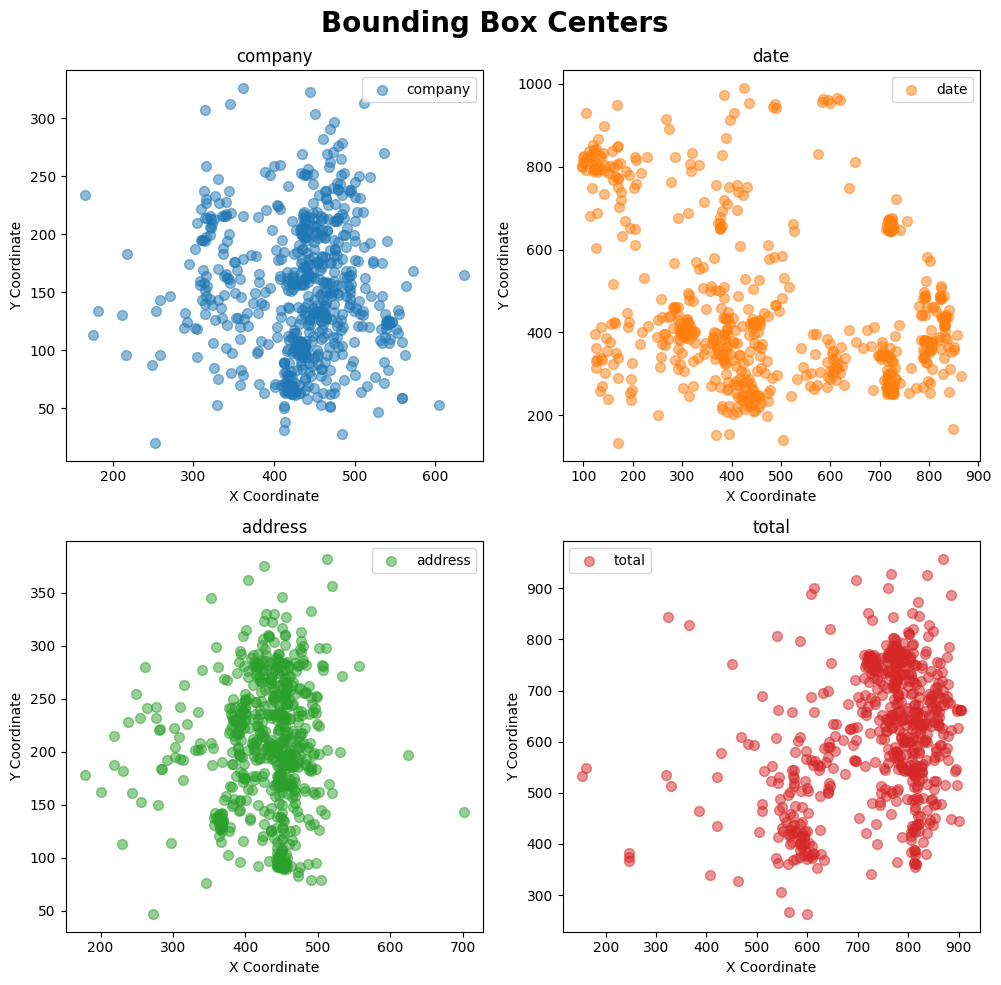

In [58]:
plot_bboxes(clean_train_df)